# Proyecto Final: Modelos de Hielo

Luis Alemán
\\ Jorge Ramírez

- Computacionalmente, el hielo ha sido estudiado desde los 60's por ser algo común y el tamaño de sus constituyentes era suficientemente pequeño (o grande) para ser estudiado numéricamente desde las primeras computadoras. 
- Desde el final del siglo XIX, se sabía que la estructura de los copos de nieve era hexagonal. No fue hasta 1929 hasta que se descubrió que es la estructura del hielo $I_h$ a presión normal.
- Después de más experimentos de difracción, se dedujo que los oxígenos formaban una red y los hidrógenos no se acomodaban en una red determinada. Más tarde se descubrió que los hidrógenos no se acomodan a la mitad entre dos oxígenos, sino que cada uno de ellos se mantiene cerca de un oxígeno en particular. Además, dos y sólo dos hidrógenos están asociados a cada oxígeno, de manera que la estructura de las moléculas de agua como unidades estructurales se preserva.
- Desde 1933 se intentó predecir arreglos de los hidrógenos, sin encontrar alguna que coincidiera con que no se formaran super-redes de hidrógenos.
- Reglas del hielo:
 1. Hay sola y necesariamente un hidrógeno en cada puente de hidrógeno.
 2. Hay exactamente dos iones hidrógeno asociados a cada oxígeno.

<img src="6config.png">

Existen muchos modelos para comprender la estructura del hielo. Durante este notebook trabajaremos con hielo "cuadrado", es decir, una red cuadrada de iones de oxígeno que están unidos por puentes de hidrógeno. Los grados de libertad con los que trabajaremos serán las posiciones de equilibrio de los iones de hidrógeno.

En 1962, Lennard planteó una bonita manera de tratar equivalentemente con este modelo de flechas, el modelo de 3 colores.
<img src="3colores.png" width=400>

###Algoritmo para modelo de 3 colores:
1. Escogemos al azar un sitio de toda la red como semilla de nuestro cluster. Este sitio tiene color A.
2. Escogemos al azar un segundo color de las otras dos posibilidades, lo llamamos color B.
3. Empezando de nuestra semilla, formamos un cluster de sitios añadiendo todos los primeros vecinos que tengan color A o color B. Paramos hasta que todos los primeros vecinos de la frontera de nuestro cluster sean color C.
4. Los colores A y B de todos los sitios del cluster son intercambiados.

####Balance detallado
Consideramos un movimiento de un estado $\mu$ a un estado $\nu$, el cual involucra un cluster de m sitios. La probabilidad de ir tomar la semilla dentro de este cluster es $m/N$. La probabilidad de escoger a un color B es $1/2$. No hay más decisiones. Por lo tanto P($\mu \rightarrow \nu)=P(\nu \rightarrow \mu$).

####Ergodicidad
Cada estado de nuestra red puede descomponerse en regiones AB rodeadas de C. Gracias al algoritmo, estas regiones AB pueden crecer o disminuir. Debido a la elección al azar, podemos llegar a un estado de la red completamente AB en un número finito de pasos. Además, estos pasos son reversibles. Hay 6 distintos estados de la red completamente AB y se puede llegar de uno a otro en un número finito de pasos (basta cambiar el color de uno solo por C, el otro no se afecta).

Las siguientes funciones son para implementar el método de los tres colores.

La función conf_i genera una configuración inicial que cumple con las reglas del hielo, es decir, no hay colores repetidos a primeros vecinos. Como nuestro algoritmo es ergódico, desde ésta configuración "cíclica" se puede llegar a cualquier otra configuración que cumpla con las reglas del hielo.

In [1]:
using PyPlot

In [3]:
function conf_i(n::Int,m::Int)
    out=zeros(n,n)
    out[1,1]=rand(0:2)
    for i in 1:n-1
        for j in 1:n-1
            out[i,j+1]=mod(out[i,j]+1,3)
        end
        out[i+1,:]=mod(out[i,:]+1,3)
    end
    
    #cuando n es 1 mod 3, hay problemas con las reglas de hielo
    if mod(n,3)==1
        out[:,n]=mod(out[:,1]+1,3)
        out[n,:]=mod(out[1,:]+1,3)
        out[n,n]=mod(out[1,1]+2,3)
    end
    out
end

conf_i (generic function with 1 method)

In [4]:
function primeros_vecinos(arreglo::Array{Float64,2},i,j)
    L1=length(arreglo[:,1])
    L2=length(arreglo[1,:])
    arreglo[mod1(i-1,L1),mod1(j,L2)],arreglo[mod1(i,L1),mod1(j-1,L2)],arreglo[mod1(i+1,L1),mod1(j,L2)],arreglo[mod1(i,L1),mod1(j+1,L2)]
end

primeros_vecinos (generic function with 1 method)

In [5]:
function indices_primeros(ij,i,j,L1,L2)
    if ij==1
        return mod1(i-1,L1),j
        elseif ij==2
        return i,mod1(j-1,L2)
        elseif ij==3
        return mod1(i+1,L1),j
        elseif ij==4
        return i,mod1(j+1,L2)
    end
end

indices_primeros (generic function with 1 method)

In [6]:
function Single_cluster(arreglo_or::Array{Float64,2})
    arreglo=copy(arreglo_or)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    #Se escoge un cuadrado al azar entre toda la red, y su número es escogido como 'colorA'
    i=rand(1:L1)
    j=rand(1:L2)
    colorA=arreglo[i,j]
    #Se escoge al azar un 'colorB' entre los restantes
    colorB=mod(rand(colorA+1:colorA+2),3)
    index_i=[i]
    index_j=[j]
    #Cambio el color de la celda inicial
    arreglo[i,j]=colorB
    red_bool[i,j]=false
    test=false
    t_limit=L1*2
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            for ij=1:4
                inew=indices_primeros(ij,index_i[n],index_j[n],L1,L2)[1]
                jnew=indices_primeros(ij,index_i[n],index_j[n],L1,L2)[2]
                if red_bool[inew,jnew]==true
                    if arreglo[inew,jnew]==colorA
                        push!(new_index_i,inew)
                        push!(new_index_j,jnew)
                        red_bool[inew,jnew]=false
                        arreglo[inew,jnew]=colorB
                        test=true
                    elseif arreglo[inew,jnew]==colorB
                        push!(new_index_i,inew)
                        push!(new_index_j,jnew)
                        red_bool[inew,jnew]=false
                        arreglo[inew,jnew]=colorA
                        test=true
                    end
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            t=t_limit
        end
        test=false
    end
    return arreglo
end

Single_cluster (generic function with 1 method)

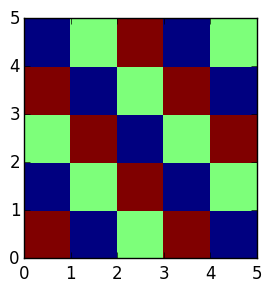

PyObject <matplotlib.collections.QuadMesh object at 0x7f9a52206a90>

In [4]:
hey=conf_i(5,5)
fig=figure(figsize=[3,3])
pcolormesh(hey)

In [7]:
function SingleCluster(arreglo::Array{Float64,2},red_bool,i,j,colorA, colorB)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    #red_bool=trues(L1,L2)
    arreglo_old=deepcopy(arreglo)
    if arreglo[i,j]==colorA
        arreglo[i,j]=colorB
    else
        arreglo[i,j]=colorA
    end
    index_i=[i]
    index_j=[j]
    red_bool[i,j]=false
    test=false
    t_limit=max(L1,L2)
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            for ii=0:1
                inew=mod1(index_i[n]+ii*2-1,L1)
                jnew=mod1(index_j[n]+ii*2-1,L2)
                if arreglo[inew,index_j[n]]==colorA && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorB
                    test=true
                end
                if arreglo[inew,index_j[n]]==colorB && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorA
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorA && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorB
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorB && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorA
                    test=true
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            t=t_limit
        end
        test=false
    end
    #Se escoge con 50% si se cambian o no los colores de este nuevo cluster 
    if rand()<0.5
        #println(":C")
        return arreglo_old,red_bool
    else
        return arreglo,red_bool
    end
end

SingleCluster (generic function with 1 method)

In [8]:
function Update!(red_bool,red_bool_dummy)
    L2=length(red_bool[1,:])
    L1=length(red_bool[:,1])
    for i in 1:L1
        for j in 1:L2
            if red_bool_dummy[i,j]==false
                red_bool[i,j]=false
            end
        end
    end
    #return red_bool
end

Update! (generic function with 1 method)

In [9]:
function MultiCluster(arreglo)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    #hey=[]
    #Se escoge al azar dos colores
    colorA=rand(0:2)
    colorB=mod(rand(colorA+1:colorA+2),3)
    for i in 1:L1
        for j in 1:L2
            if red_bool[i,j]==true
                if arreglo[i,j]==colorA || arreglo[i,j]==colorB
                    arreglo,red_bool_dummy=SingleCluster(arreglo,red_bool,i,j,colorA,colorB)
                    Update!(red_bool,red_bool_dummy)
                end
            end
        end
    end
    return arreglo
end

MultiCluster (generic function with 1 method)

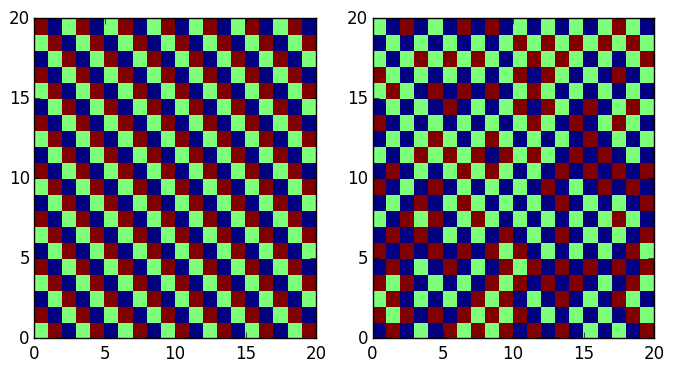

PyObject <matplotlib.collections.QuadMesh object at 0x7f9a2bd19750>

In [351]:
hey_old=conf_i(20,20)
hey=copy(hey_old)
for t in 1:1000
    hey_new=MultiCluster(hey_old)
    hey_new,hey_old=hey_old,hey_new
end
figure(figsize=[8,4])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(hey)

subplot(1,2,2)
pcolormesh(hey_old)

#Energías

Existen muchos modelos energéticos para el arreglo de los Hidrógenos en los Oxígenos. Trabajaremos con el modelo $F$ que favorece los arreglos simétricos. Para el modelo de 3 colores, esto se traduce en parejas de segundos vecinos (diagonales) del mismo color. El hamiltoniano se transforma entonces:
$$H=-\epsilon \sum \limits_{[i,j]}(\delta_{c_ic_j} - \frac{1}{2})=N\epsilon - \epsilon \sum \limits_{[i,j]}\delta_{c_ic_j}$$

El algoritmo entonces para crear clusters que favorezcan parejas de segundos vecinos del mismo color dependiente de la temperatura será:
1. Escogemos un cuadro de toda la red como semilla de nuestro cluster. Este cuadro tiene color A.
2. Escogemos un segundo color de las otras dos posibilidades, lo llamamos color B.
3. Empezando de nuestra semilla, formamos un cluster de cuadros añadiendo todos los primeros vecinos que tengan color A o color B, pero además ahora incluiremos con probablidad $P_{add}(T)$ a los segundos vecinos del cuadro $i$ que ya está en el cluster con la condición que tengan el mismo color que $i$.
4. Los colores A y B de todos los cuadros del cluster son intercambiados.

$$P_{add}=1-e^{-\beta \epsilon}$$

Esta última expresión se desarrolla en la presentación.

In [10]:
function segundos_vecinos(arreglo::Array{Float64,2},i,j)
    L1=length(arreglo[:,1])
    L2=length(arreglo[1,:])
    arreglo[mod1(i-1,L1),mod1(j-1,L2)],arreglo[mod1(i-1,L1),mod1(j+1,L2)],arreglo[mod1(i+1,L1),mod1(j-1,L2)],arreglo[mod1(i+1,L1),mod1(j+1,L2)]
end

segundos_vecinos (generic function with 1 method)

In [11]:
function indices_segundos(ij,i,j,L1,L2)
    if ij==1
        return mod1(i-1,L1),mod1(j-1,L2)
        elseif ij==2
        return mod1(i-1,L1),mod1(j+1,L2)
        elseif ij==3
        return mod1(i+1,L1),mod1(j-1,L2)
        elseif ij==4
        return mod1(i+1,L1),mod1(j+1,L2)
    end
end

indices_segundos (generic function with 1 method)

In [12]:
function contador_segundos(arreglo::Array{Float64,2})
    L1=length(arreglo[:,1])
    L2=length(arreglo[1,:])
    contador=0
    for i in 1:L1
        for j in 1:L2
            segundo=segundos_vecinos(arreglo,i,j)
            for ij in 1:4
                if segundo[ij]==arreglo[i,j]
                    contador+=1
                end
            end
        end
    end
    contador/2
end

contador_segundos (generic function with 1 method)

In [9]:
2 == 3 && 
2 == 2

false

In [13]:
function Single_cluster_E(β,arreglo_or::Array{Float64,2},ϵ=1.0)
    arreglo=copy(arreglo_or)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    P_add=1-e^(-β*ϵ)
    #Se escoge un cuadrado al azar entre toda la red, y su número es escogido como 'colorA'
    i=rand(1:L1)
    j=rand(1:L2)
    colorA=arreglo[i,j]
    #Se escoge al azar un 'colorB' entre los restantes
    colorB=mod(rand(colorA+1:colorA+2),3)
    index_i=[i]
    index_j=[j]
    colorC=3-(colorA+colorB)
    #Cambio el color de la celda inicial
    arreglo[i,j]=colorB
    red_bool[i,j]=false
    test=false
    t_limit=L1*2
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            #Primeros vecinos
            for ij=1:4
                inew=indices_primeros(ij,index_i[n],index_j[n],L1,L2)[1]
                jnew=indices_primeros(ij,index_i[n],index_j[n],L1,L2)[2]
                if red_bool[inew,jnew]==true
                    if arreglo[inew,jnew]==colorA
                        push!(new_index_i,inew)
                        push!(new_index_j,jnew)
                        red_bool[inew,jnew]=false
                        arreglo[inew,jnew]=colorB
                        test=true
                    elseif arreglo[inew,jnew]==colorB
                        push!(new_index_i,inew)
                        push!(new_index_j,jnew)
                        red_bool[inew,jnew]=false
                        arreglo[inew,jnew]=colorA
                        test=true
                    end
                end
            end
            #Segundos vecinos
            segundo=segundos_vecinos(arreglo,index_i[n],index_j[n])
            for ij in 1:4
                ii_new=indices_segundos(ij,index_i[n],index_j[n],L1,L2)[1]
                jj_new=indices_segundos(ij,index_i[n],index_j[n],L1,L2)[2]
                if segundo[ij] !=arreglo[index_i[n],index_j[n]] && segundo[ij] !=colorC &&
                    red_bool[ii_new,jj_new]==true
                    if rand()<P_add
                        push!(new_index_i,ii_new)
                        push!(new_index_j,jj_new)
                        red_bool[ii_new,jj_new]=false
                        if arreglo[index_i[n],index_j[n]]==colorA
                                arreglo[ii_new,jj_new]=colorA
                        else
                                arreglo[ii_new,jj_new]=colorB
                        end
                        test=true
                    end
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            #println("there are no more squares to add")
            t=t_limit
        end
        test=false
    end
    return arreglo
end

Single_cluster_E (generic function with 2 methods)

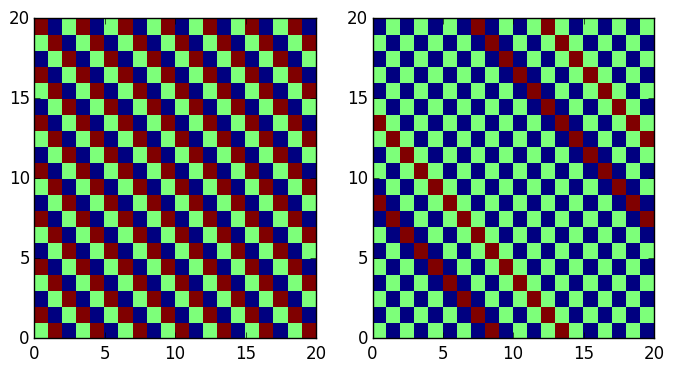

PyObject <matplotlib.collections.QuadMesh object at 0x7f9a34d8ad90>

In [12]:
inicial_s=conf_i(20,20)
old=copy(inicial_s)
for t in 1:10
    new=Single_cluster_E(1000.0,old)
    new,old=old,new
end
figure(figsize=[8,4])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial_s)

subplot(1,2,2)
pcolormesh(old)

In [14]:
contador_segundos(inicial_s),contador_segundos(old)

(400.0,712.0)

In [15]:
old=conf_i(20,20)
betas=[i*0.2 for i in 0:20]
out=zeros(length(betas))
@time for i in 1:length(betas)
    for t in 1:1000
        new=Single_cluster_E(betas[i],old)
        old,new=new,old
    end
    out[i]=contador_segundos(old)
end

elapsed time: 67.850660394 seconds (7705110640 bytes allocated, 19.71% gc time)


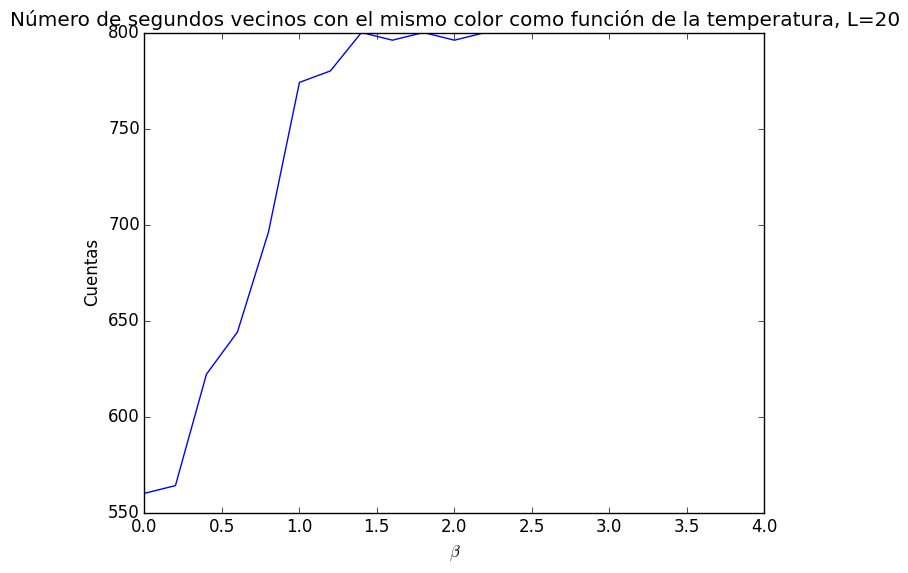

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc4900c1e50>

In [39]:
title("Número de segundos vecinos con el mismo color como función de la temperatura, L=20")
xlabel(L"$\beta$")
ylabel("Cuentas")
plot(betas,out)

###A medida que la temperatura baja, vemos que es más fácil aceptar los cambios y el número de segundos vecinos con el mismo color tiende a su máximo de 2N

In [22]:
old=conf_i(30,30)
inicial=copy(old)
for t in 1:1000
    new=Single_cluster_E(0.1,old)
    old,new=new,old
end

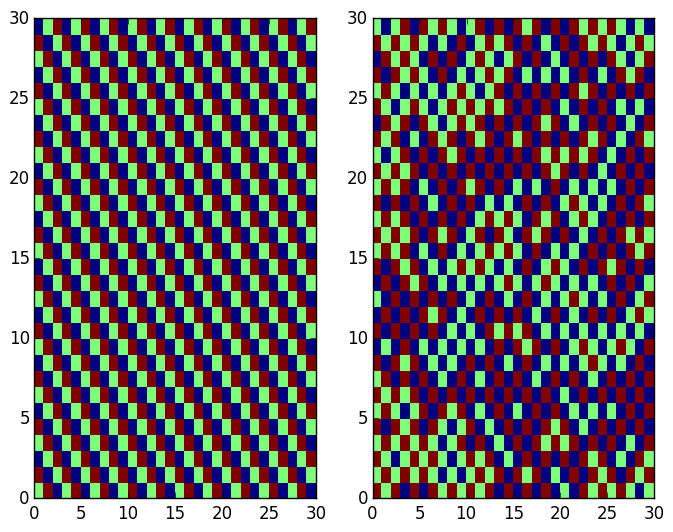

PyObject <matplotlib.collections.QuadMesh object at 0x7f262fba1a10>

In [23]:
figure(figsize=[8,6])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old)

#A partir de aquí las cosas funcionan tan bien, multicluster.

In [14]:
function conf_random(L1::Int,L2::Int,pasos=30)
    old=conf_i(L1,L2)
    for t in 1:pasos
        new=MultiCluster(old)
        new,old=old,new
    end
    old
end

conf_random (generic function with 2 methods)

In [15]:
function SingleCluster_E(β,arreglo::Array{Float64,2},red_bool,i,j,colorA,colorB,colorC,ϵ=1.0)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    P_add=1-e^(-β*ϵ)
    arreglo_old=copy(arreglo)
    if arreglo[i,j]==colorA
        arreglo[i,j]=colorB
    else
        arreglo[i,j]=colorA
    end
    index_i=[i]
    index_j=[j]
    red_bool[i,j]=false
    test=false
    t_limit=max(L1,L2)
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            for ii=0:1
                inew=mod1(index_i[n]+ii*2-1,L1)
                jnew=mod1(index_j[n]+ii*2-1,L2)
                if arreglo[inew,index_j[n]]==colorA && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorB
                    test=true
                end
                if arreglo[inew,index_j[n]]==colorB && red_bool[inew,index_j[n]]==true
                    push!(new_index_i,inew)
                    push!(new_index_j,index_j[n])
                    red_bool[inew,index_j[n]]=false
                    arreglo[inew,index_j[n]]=colorA
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorA && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorB
                    test=true
                end
                if arreglo[index_i[n],jnew]==colorB && red_bool[index_i[n],jnew]==true
                    push!(new_index_i,index_i[n])
                    push!(new_index_j,jnew)
                    red_bool[index_i[n],jnew]=false
                    arreglo[index_i[n],jnew]=colorA
                    test=true
                end
            end
            segundo=segundos_vecinos(arreglo,index_i[n],index_j[n])
            for ij in 1:4
                ii_new=indices_segundos(ij,index_i[n],index_j[n],L1,L2)[1]
                jj_new=indices_segundos(ij,index_i[n],index_j[n],L1,L2)[2]
                if segundo[ij] !=arreglo[index_i[n],index_j[n]] && segundo[ij] !=colorC && red_bool[ii_new,jj_new]==true
                    if rand()<P_add
                    #println("aceptó")
                        push!(new_index_i,ii_new)
                        push!(new_index_j,jj_new)
                        red_bool[ii_new,jj_new]=false
                        if arreglo[index_i[n],index_j[n]]==colorA
                                arreglo[ii_new,jj_new]=colorA
                        else
                                arreglo[ii_new,jj_new]=colorB
                        end
                        test=true
                    end
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            t=t_limit
        end
        test=false
    end
    if rand()<0.5
        #println(":C")
        return arreglo_old,red_bool
    else
        return arreglo,red_bool
    end
end

SingleCluster_E (generic function with 2 methods)

In [16]:
function MultiCluster_E(β,arreglo_or,ϵ=1.0)
    arreglo=copy(arreglo_or)
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    #Se escoge al azar dos colores
    colorA=rand(0:2)
    colorB=mod(rand(colorA+1:colorA+2),3)
    colorC=3-(colorA+colorB)
    for i in 1:L1
        for j in 1:L2
            if red_bool[i,j]==true
                if arreglo[i,j]==colorA || arreglo[i,j]==colorB
                    arreglo,red_bool_dummy=SingleCluster_E(β,arreglo,red_bool,i,j,colorA,colorB,colorC)
                    Update!(red_bool,red_bool_dummy)
                end
            end
        end
    end
    return arreglo
end

MultiCluster_E (generic function with 2 methods)

####Si se usara como distribución inicial, las diagonales

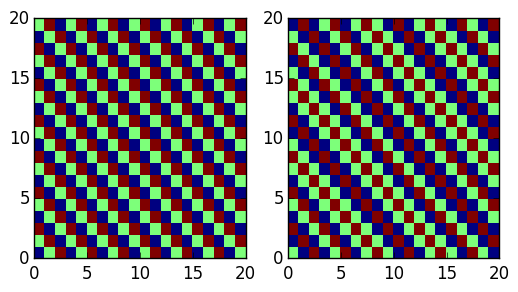

PyObject <matplotlib.collections.QuadMesh object at 0x7f262dd0b890>

In [54]:
inicial=conf_i(20,20)
old=copy(inicial)
for t in 1:2
    new=MultiCluster_E(1000.0,old)
    new,old=old,new
end
figure(figsize=[6,3])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old)

####Hasta converge "endiabladamente" rápido

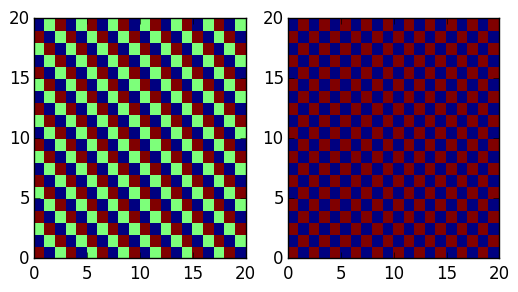

PyObject <matplotlib.collections.QuadMesh object at 0x7f262d350210>

In [60]:
inicial=conf_i(20,20)
old=copy(inicial)
for t in 1:20
    new=MultiCluster_E(1000.0,old)
    new,old=old,new
end
figure(figsize=[6,3])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old)

##Usando como configuración inicial una configuración procesada por Multicluster sin energía después de 50 pasos:

In [46]:
inicial=conf_random(100,100);

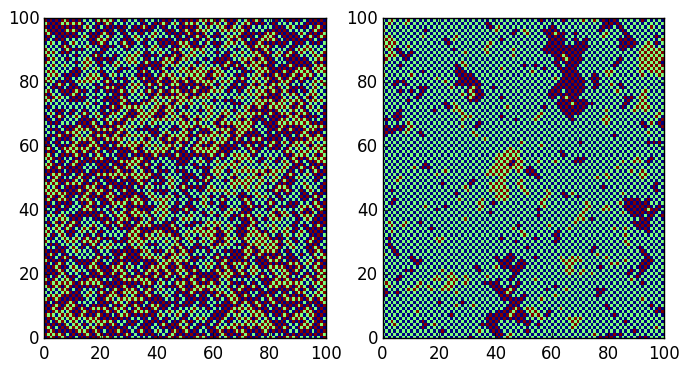

PyObject <matplotlib.collections.QuadMesh object at 0x7f9a304564d0>

In [54]:
old_M=copy(inicial)
for t in 1:10
    new=MultiCluster_E(1.0,old_M)
    new,old_M=old_M,new
end

figure(figsize=[8,4])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old_M)

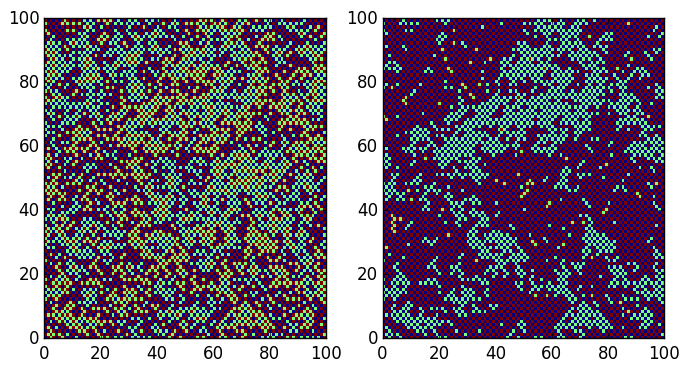

PyObject <matplotlib.collections.QuadMesh object at 0x7f9a2fb06050>

In [55]:
old_S=copy(inicial)
for t in 1:10
    new=Single_cluster_E(1.0,old_S)
    new,old_S=old_S,new
end

figure(figsize=[8,4])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,2,2)
pcolormesh(old_S)

In [56]:
contador_segundos(old_M), contador_segundos(old_S)

(18176.0,17208.0)

##La energía estará dada por el número de segundos vecinos del mismo color:

In [17]:
function contadorespromedio_beta(configuracion_inicial::Array{Float64,2},β_max=5.0,t_max=50,intervalos=20)
    betas=[0:β_max/intervalos:β_max]
    maximo=length(betas)
    out=zeros(maximo)
    for i in 1:maximo
        old=copy(configuracion_inicial)
        for t in 1:t_max
            new=Single_cluster_E(betas[i],old)
            out[i]+=contador_segundos(new)
            new,old=old,new
        end
        out[i]=out[i]/t_max
    end
    out
end

contadorespromedio_beta (generic function with 4 methods)

In [21]:
function energiaspromedio_beta(configuracion_inicial::Array{Float64,2},β_max=5.0,t_max=50,intervalos=20)
    L1=length(configuracion_inicial[:,1])
    L2=length(configuracion_inicial[1,:])
    1-contadorespromedio_beta(configuracion_inicial::Array{Float64,2},β_max,t_max,intervalos)/(L1*L2)
end

energiaspromedio_beta (generic function with 4 methods)

elapsed time: 221.901209903 seconds (54965193168 bytes allocated, 38.43% gc time)


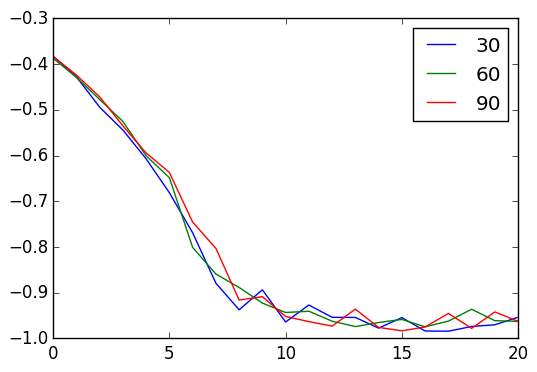

In [51]:
L_max=90
tamaños=[30:30:L_max]
maximo=length(tamaños)
out=zeros(maximo,21)
figure(figsize=[6,4])
@time for i in 1:maximo
    config=conf_random(tamaños[i],tamaños[i],15)
    plot(energiaspromedio_beta(config,3.0,70),label=tamaños[i])
    legend()
end

In [26]:
@time promedios=contadorespromedio_beta(config,2.0,200);

elapsed time: 106.500257097 seconds (21622288892 bytes allocated, 32.39% gc time)


[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]


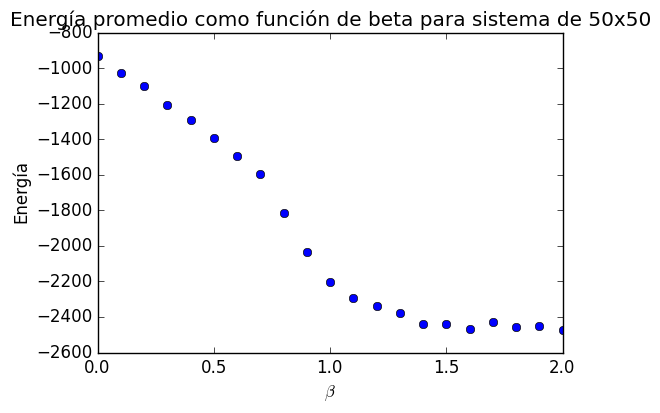

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa2799ceb50>

In [27]:
L1=L2=50
Energias=L1*L2.-promedios
β_max=2.0
intervalos=20
figure(figsize=[6,4])
title("Energía promedio como función de beta para sistema de 50x50")
xlabel(L"$\beta$")
ylabel("Energía")
println([0:β_max/intervalos:β_max])
plot([0:β_max/intervalos:β_max],Energias,"o")

Y notamos que hay una transición de fase aproximadamente entre $\beta=0.5$ y $1.0$.

###Veamos cómo escala el número de segundos vecinos del mismo color con el tamaño del sistema para un tiempo y temperatura fijos.

In [284]:
function tiempo_sistema_S(β,original::Array{Float64,2},t_max=1000)
    old=copy(original)
    t=0
    tic()
    while t<t_max
        new=Single_cluster_E(β,old)
        if abs(contador_segundos(new)-contador_segundos(old))<1.0
            return toq()
        end
        new,old=old,new
        t+=1
    end
end

tiempo_sistema_S (generic function with 4 methods)

In [267]:
function tiempos_S(β,L_max,paso,t_promedio=10)
    tamaños=[10:paso:L_max]
    maximo=length(tamaños)
    out=zeros(maximo)
    for L in 1:maximo
        old=conf_random(tamaños[L],tamaños[L],15)
        for t in 1:t_promedio
            out[L]+=tiempo_sistema_S(β,old)
        end
    end
    out./t_promedio
end

tiempos_S (generic function with 2 methods)

In [285]:
function tiempo_sistema_M(β,original::Array{Float64,2},t_max=1000)
    old=copy(original)
    t=0
    tic()
    while t<t_max
        new=MultiCluster_E(β,old)
        if abs(contador_segundos(new)-contador_segundos(old))<1.0
            return toq()
        end
        new,old=old,new
        t+=1
    end
end

tiempo_sistema_M (generic function with 4 methods)

In [270]:
function tiempos_M(β,L_max,paso,t_promedio=10)
    tamaños=[10:paso:L_max]
    maximo=length(tamaños)
    out=zeros(maximo)
    for L in 1:maximo
        old=conf_random(tamaños[L],tamaños[L],15)
        for t in 1:t_promedio
            out[L]+=tiempo_sistema_M(β,old)
        end
    end
    out./t_promedio
end

tiempos_M (generic function with 2 methods)

In [332]:
old=conf_random(70,70,20);

In [334]:
tiempo_sistema_S(1.0,old),tiempo_sistema_M(1.0,old)

(0.656465882,2.175220033)

In [277]:
@time tS=tiempos_S(0.7,110,50,2)

elapsed time: 20.239008436 seconds (4995601616 bytes allocated, 41.89% gc time)


3-element Array{Float64,1}:
 0.00392764
 0.57562   
 2.87053   

In [278]:
@time tM=tiempos_M(0.7,110,50,2)

elapsed time: 96.663583106 seconds (23133218312 bytes allocated, 41.86% gc time)


3-element Array{Float64,1}:
  0.00266435
 13.28      
 28.7971    

Vemos que a pesar de que el libro nos decía que Multicluster es más rápido, nuestra implementación resultó ser más lenta...

#Algoritmo con flechas

Como se puede observar en la fig. 2, todo el tratamiento anterior se puede implementar no con colores, sino usando las mismas flechas que corresponden a los sitios de los Hidrógenos. Lo que se hizo fue hacer una red de flechas girando nuestra configuración 45°, de manera que cada puente de hidrógeno cae en un sitio de esta nueva red.

<img src="flechas.png" width=400>

Así mismo, es importante recalcar que al hacer esto, no todos los nuevos vértices de esta representación eran un vértice en la red original. Afortunadamente, los casos se reducen a celdas par-par/impar-impar y par-impar (hablando de la entrada ij), y esto hay que tomarlo en cuenta al momento de implementar el algoritmo. En la siguiente imagen se muestra con un recuadro rojo un ejemplo de celda par-par, y en azul par-impar, nótese la diferencia en la posición de los vértices reales de la red original y los siguientes pasos admisibles desde esas flechas.

<img src="dos_casos.png" width=400>

Así, se le puede asignar un valor de -1 o 1 a cada sitio que corresponde a la orientación de la flecha. 

Por último, como se mencionó al principio, sólo hay 6 tipos de vértices en estas redes, y su representación en este sistema son casillas rodeando vértices reales con un número par de -1 y/o 1, nunca números impares.

####Existen dos algoritmos que se usan para generar arreglos que cumplan con las reglas del hielo: long loop y short loop. 

La idea es comenzar en un sitio elegido aleatoriamente y cambiar la orientación de una flecha. Como antes se cumplían las reglas del hielo, con este flip ya no se logra, por lo que este vértice se corrige cambiando otra flecha cualquiera que haga cumplirse las reglas del hielo. Como deben de cumplirse las reglas de hielo, en la implementación de decidió siempre voltear flechas que apuntaban al vértice en cuestión, así, después del cambio saldrían del vértice. Esto último reduce las opciones en los pasos a 2 en lugar de 3 (com ose mostraba en la figura pasada).

- Long loop: se repite este procedimiento hasta regresar al punto inicial. Como se cerró el ciclo, se corrigieron todos los vértices y llegamos a una configuración equivalente que cumple las reglas del hielo.

- Short loop: se repite el procedimiento hasta que la trayectoria se cruce, generando un ciclo cerrado con una "cola". El ciclo cerrado cumple ya con las reglas del hielo, y lo que se hace es regresar por la trayectoria que no cayó dentro del ciclo cerrado y voltear las flechas de regreso.

Una combinación inicial que cumple las reglas del hielo son todas las flechas apuntando hacia arriba o hacia abajo, i.e., arreglos de puros 1's o -1's, que son arreglos completamente antisimétricos. Otra posible configuración inicial sería la totalmente simétrica, que está dada por arreglos de columnas intercaladas de 1's y -1's. Se optó por la primer opción por ser más sencilla. Por último, por cuestiones de periodicidad en la frontera, sólo se puede implementar en arreglos con numero par de columnas y renglones.

####Long loop

In [2]:
function Config(L)
    if mod(L,2)!=0
        L+=1
    end
    config=ones(L,L)
    return config
end

Config (generic function with 1 method)

In [3]:
function Initialize(i,j,config,red_bool)
    L=length(config[1,:])
    #Cambio la flecha inicial
    config[i,j]*=-1
    #sign indica si la celda es 1)par-par o impar-impar, o 2) par-impar
    sign=(-1)^abs(mod(i,2)-mod(j,2))
    #se marca la zona de retorno de tal forma que la flecha volteada haya sido una ingoing y no una outgoing
    red_bool[i,j]=false
    red_bool[mod1(i+config[i,j],L),mod1(j+sign*config[i,j],L)]=false
    red_bool[mod1(i+config[i,j],L),j]=false
    red_bool[i,mod1(j+sign*config[i,j],L)]=false
    return config, red_bool
end

Initialize (generic function with 1 method)

In [4]:
function Step(i,j,config)
    L=length(config[1,:])
    #sign no indica la dirección de la flecha, sino lo que será según sea 1)par-par o impar-impar, o 2) par-impar
    sign=(-1)^abs(mod(i,2)-mod(j,2))
    #checo el caso de vértice que es: simétrico o asimétrico
    #otra opción es config[i,j]==config[mod1(i-config[i,j],L),mod1(j-sign*config[i,j]])]
    if config[mod1(i-config[i,j],L),j]==-config[i,mod1(j-sign*config[i,j],L)]
        step=round(rand())
        i_new=mod1(i-config[i,j]*step,L)
        j_new=mod1(j-sign*config[i,j]*(1-step),L)
    else
        #la parte antisimétrica tiene dos opciones
        if config[i,j]==config[mod1(i-config[i,j],L),j]
            j_new=mod1(j-sign*config[i,j],L)
            i_new=mod1(i-config[i,j]*round(rand()),L)
        else
            i_new=mod1(i-config[i,j],L)
            j_new=mod1(j-sign*config[i,j]*round(rand()),L)
        end
    end
    return i_new,j_new
end

Step (generic function with 1 method)

In [5]:
function Long_loop(config)
    #El modelo que implemento sólo es compatible con redes "pares" por las condiciones periódicas
    L=length(config[1,:])
    red_bool=trues(L,L)
    #escojo la celda inicial
    i=rand(1:L)
    j=rand(1:L)
    i_array=[i]
    j_array=[j]
    #Se escoge la dirección del inicial
    config,red_bool=Initialize(i,j,config,red_bool)
    #Se inicia la creación del loop
    t=1
    t_limit=L*L*L*L
    while t < t_limit
        #calculo el nuevo paso
        i_new,j_new=Step(i_array[t],j_array[t],config)
        push!(i_array,i_new)
        push!(j_array,j_new)
        config[i_new,j_new]*=-1
        #si ya se llegó a la zona de retorno, se termina el loop
        if red_bool[i_new,j_new]==false
            t=t_limit
        end
        t+=1
    end
    return config
end

Long_loop (generic function with 1 method)

####Probamos el Long-loop

elapsed time: 0.128311098 seconds (4 MB allocated, 22.75% gc time in 1 pauses with 0 full sweep)


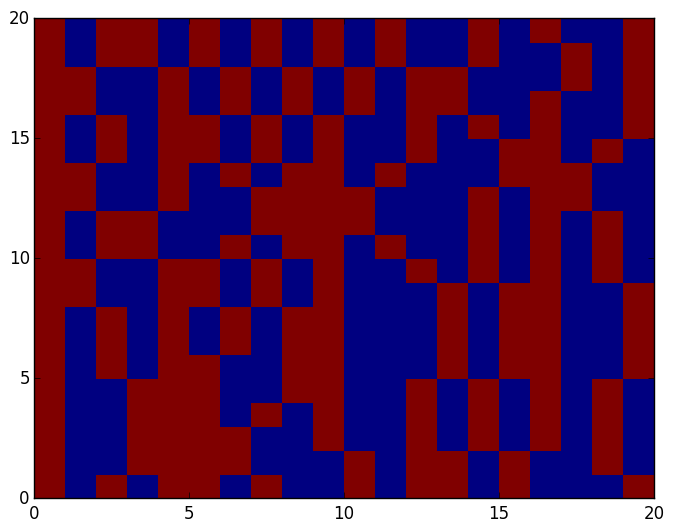

PyObject <matplotlib.collections.QuadMesh object at 0x314cec550>

In [11]:
original=Config(20)
new=copy(original)
@time for t in 1:100
    meanwhile=Long_loop(new)
    new=meanwhile
end
pcolormesh(new)

Vemos que cumple con las reglas del hielo ya que en las casillas al rededor de vértices reales nunca es impar, ni combinaciones prohibidas. 

####Short loop

In [6]:
function Reverse(i_array,j_array,config)
    t_last=length(i_array)
    L=length(config[1,:])
    a=[0,0,0]
    b=[0,0,0]
    sign=(-1)^abs(mod(i_array[t_last],2)-mod(j_array[t_last],2))
    #marco las coordenadas de las posibles celdas que pertenezcan al camino
    a[1]=mod1(i_array[t_last]-config[i_array[t_last],j_array[t_last]],L)
    b[1]=mod1(j_array[t_last]-sign*config[i_array[t_last],j_array[t_last]],L)
    a[2]=mod1(i_array[t_last]-config[i_array[t_last],j_array[t_last]],L)
    b[2]=j_array[t_last]
    a[3]=i_array[t_last]
    b[3]=mod1(j_array[t_last]-sign*config[i_array[t_last],j_array[t_last]],L)
    counter=0 
    bool=true
    #encuentro las celdas que corresponden y de ahí revierto lo hecho          
     for i in 1:t_last-1
        if counter<1
            for s in 1:3
                if i_array[t_last-i]==a[s] && j_array[t_last-i]==b[s]
                    counter+=1
                end
            end
        else
            config[i_array[t_last-i],j_array[t_last-i]]*=-1
        end
    end
    return config
end

Reverse (generic function with 1 method)

In [7]:
function Short_loop(config)
    #El modelo que implemento sólo es compatible con redes "pares" por las condiciones periódicas
    L=length(config[1,:])
    red_bool=trues(L,L)
    #escojo la celda inicial
    i=rand(1:L)
    j=rand(1:L)
    i_array=[i]
    j_array=[j]
    #Se escoge la dirección del inicial
    config,red_bool=Initialize(i,j,config,red_bool)
    #Se inicia la creación del loop
    t=1
    t_limit=L*L*L*L
    while t < t_limit
        #calculo el nuevo paso
        i_new,j_new=Step(i_array[t],j_array[t],config)
        push!(i_array,i_new)
        push!(j_array,j_new)
        config[i_new,j_new]*=-1
        sign=(-1)^abs(mod(i_array[t+1],2)-mod(j_array[t+1],2))
        #si ya se llegó a la zona de retorno, se termina el loop
        if red_bool[i_new,j_new]==false
            t=t_limit
        end
        #marco las nuevas zonas de retorno
        red_bool[i_new,j_new]=false
        red_bool[mod1(i_new+config[i_new,j_new],L),mod1(j_new+sign*config[i_new,j_new],L)]=false
        red_bool[mod1(i_new+config[i_new,j_new],L),j_new]=false
        red_bool[i_new,mod1(j_new+sign*config[i_new,j_new],L)]=false
        t+=1
    end
    config=Reverse(i_array,j_array,config)
    return config
end

Short_loop (generic function with 1 method)

####Probamos el short loop

elapsed time: 0.093191596 seconds (6799252 bytes allocated)


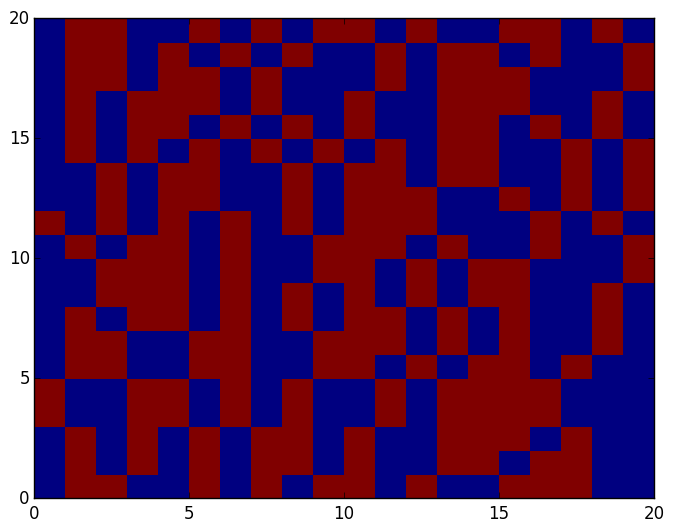

PyObject <matplotlib.collections.QuadMesh object at 0x7fa1e57d31d0>

In [10]:
original=Config(20)
new=copy(original)
@time for t in 1:1000
    meanwhile=Short_loop(new)
    new=meanwhile
end
pcolormesh(new)

Muchos "ciclos" o "pasos" toman poco tiempo, mucho menos que el long loop.

##Comparación

elapsed time: 2.393680961 seconds (1468161364 bytes allocated, 73.41% gc time)


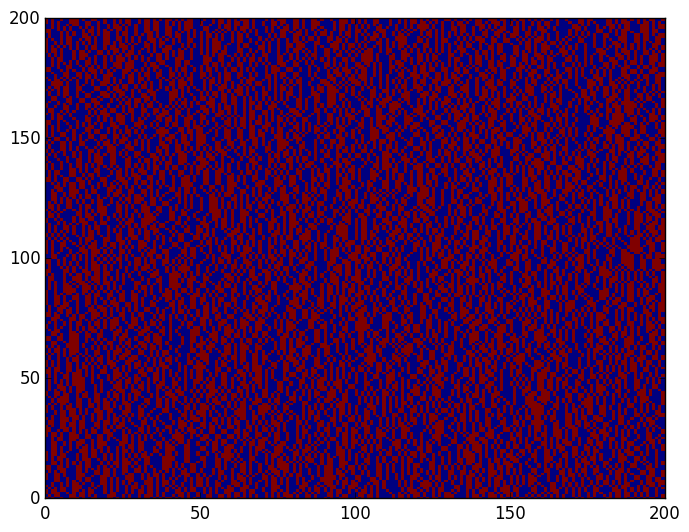

PyObject <matplotlib.collections.QuadMesh object at 0x7fa1cb1bd890>

In [11]:
original=Config(200)
new=copy(original)
@time for t in 1:100
    new=Long_loop(new)
end
pcolormesh(new)

Este da un tiempo $t$ por ciclo de  $t<0.01$ seg

elapsed time: 113.571465961 seconds (66728911200 bytes allocated, 67.36% gc time)


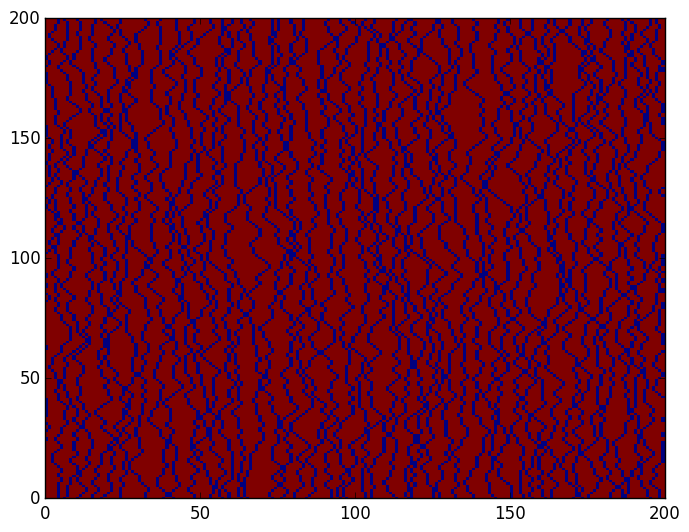

PyObject <matplotlib.collections.QuadMesh object at 0x7fa1c9a4c390>

In [13]:
original=Config(200)
new=copy(original)
@time for t in 1:1000000
    new=Short_loop(new)
end
pcolormesh(new)

Este da un tiempo $t$ por ciclo de  $t<10^{-5}$ seg

Al parecer el loop corto no termina mezclando todo el mapa y genera lineas al principio verticales que responden al estado incial, que es que todas las flechas apunten hacia arrbia (rojo), y por la construcción, escoge irse hacia "abajo" (sus opciones por lo general son hacia abajo, hasta que tope otro azul).

El shortloop de la manera en que lo implementamos no es tan eficiente debido a que tiene que checar toda su cadena para voltear los espines. Al parecer requiere muchos más "pasos" para generar un arreglo random, pero estos le toman demasiado tiempo, aunque es claro que el short loop es más rápido en realizar sus ciclos, no lo es tanto como debería.

##Modelos energéticos

La idea es usar el longloop para generar arrerglos random que respeten las leyes de hielo y luego correr los modelos energéticos. Se uso el llamado modelo F, en que se da preferencia a los arreglos simétricos con una energía $-\epsilon$, y no a los antisimétricos con energía cero.

In [8]:
function Initialize_E(i,j,config,red_bool)
    Delta_n=0
    L=length(config[1,:])
    #Cambio la flecha inicial
    config[i,j]*=-1
    #sign indica si la celda es 1)par-par o impar-impar, o 2) par-impar
    sign=(-1)^abs(mod(i,2)-mod(j,2))
    #se marca la zona de retorno de tal forma que la flecha volteada haya sido una ingoing y no una outgoing
    red_bool[i,j]=false
    red_bool[mod1(i+config[i,j],L),mod1(j+sign*config[i,j],L)]=false
    red_bool[mod1(i+config[i,j],L),j]=false
    red_bool[i,mod1(j+sign*config[i,j],L)]=false
    #checo si al inicio fue un vértice simétrico y lo "destruimos", pasando a un arreglo más energético
    if config[i,j]==config[mod1(i+config[i,j],L),mod1(j+sign*config[i,j],L)]
        Delta_n+=1 
    end
    return config, red_bool, Delta_n
end

Initialize_E (generic function with 1 method)

In [9]:
function Step_E(i,j,config)
    Delta_n=0
    L=length(config[1,:])
    #sign no indica la dirección de la flecha, sino lo que será según sea 1)par-par o impar-impar, o 2) par-impar
    sign=(-1)^abs(mod(i,2)-mod(j,2))
    #checo el caso de vértice que es: simétrico o asimétrico
    #otra opción es config[i,j]==config[mod1(i-config[i,j],L),mod1(j-sign*config[i,j]])]
    if config[mod1(i-config[i,j],L),j]==-config[i,mod1(j-sign*config[i,j],L)]
        step=round(rand())
        i_new=mod1(i-config[i,j]*step,L)
        j_new=mod1(j-sign*config[i,j]*(1-step),L)
        #se destruye el vértice simétrico y se va a un estado de mayor energía
        Delta_n+=1
    else
        r=round(rand())
        #la parte antisimétrica tiene dos opciones
        if config[i,j]==config[mod1(i-config[i,j],L),j]
            j_new=mod1(j-sign*config[i,j],L)
            i_new=mod1(i-config[i,j]*r,L)
        else
            i_new=mod1(i-config[i,j],L)
            j_new=mod1(j-sign*config[i,j]*r,L)
        end
        #si da una vuelta de 90 grados, entonces se generará un vértice simétrico de menor energía
        if r==0
            Delta_n-=1
        end
    end
    return i_new,j_new,Delta_n
end

Step_E (generic function with 1 method)

In [10]:
function Ending_E(i,j,config)
    Delta=0
    L=length(config[1,:])
    sign=(-1)^abs(mod(i,2)-mod(j,2))
    #checo si el vértice final termina siendo simétrico o no
    if config[i,j]==-config[mod1(i-config[i,j],L),mod1(j-sign*config[i,j],L)]
        Delta-=1 
    end
    return Delta    
end

Ending_E (generic function with 1 method)

In [11]:
function Long_loop_E(config,T,ϵ=1)
    #El modelo que implemento sólo es compatible con redes "pares" por las condiciones periódicas
    L=length(config[1,:])
    old_config=copy(config)
    red_bool=trues(L,L)
    #escojo la celda inicial
    i=rand(1:L)
    j=rand(1:L)
    i_array=[i]
    j_array=[j]
    #Se escoge la dirección del inicial
    config,red_bool,Delta_n=Initialize_E(i,j,config,red_bool)
    #Se inicia la creación del loop
    t=1
    t_limit=L*L*L*L
    while t < t_limit
        #calculo el nuevo paso
        i_new,j_new,Delta=Step_E(i_array[t],j_array[t],config)
        Delta_n+=Delta
        push!(i_array,i_new)
        push!(j_array,j_new)
        config[i_new,j_new]*=-1
        #si ya se llegó a la zona de retorno, se termina el loop
        if red_bool[i_new,j_new]==false
            t=t_limit
            Delta=Ending_E(i_new,j_new,config)
            Delta_n+=Delta
        end
        t+=1
    end
    #checo si acepta o no la cadena generada
    #println(Delta_n)
    if Delta_n>0
        Probability=exp(-(Delta_n*ϵ)/T)
    else
        Probability=1
    end
    if rand()<Probability
        return config
    else
        return old_config
    end
end

Long_loop_E (generic function with 2 methods)

elapsed time: 3.450192725 seconds (1966 MB allocated, 12.57% gc time in 90 pauses with 0 full sweep)


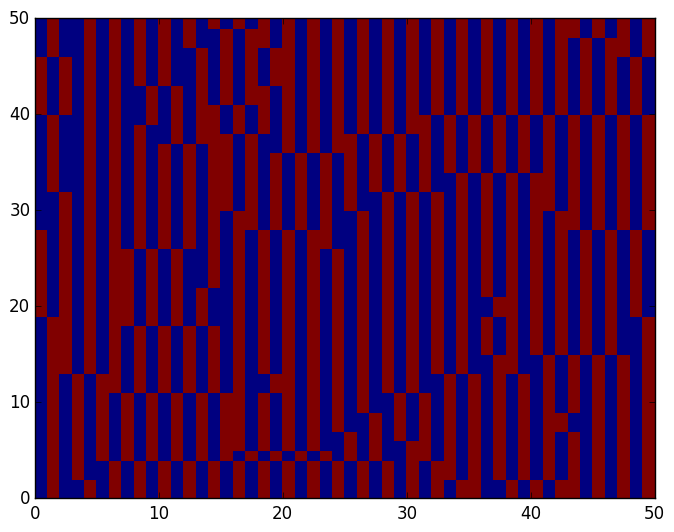

PyObject <matplotlib.collections.QuadMesh object at 0x313e6a2d0>

In [12]:
original=Config(50)
new=copy(original)
@time for t in 1:10000
    new=Long_loop_E(new,0.3)
end
pcolormesh(new)

Como vemos funciona, ya que el sistema tiende a los vértices simétricos, que como se mencionó al inicio de la sección de flechas, están dados por columnas intercaladas de 1 y -1, i.e. franjas azúles y rojas.

####Short loop

In [13]:
function Reverse_E(i_array,j_array,config,Delta_n)
    t_last=length(i_array)
    L=length(config[1,:])
    a=[0,0,0]
    b=[0,0,0]
    sign=(-1)^abs(mod(i_array[t_last],2)-mod(j_array[t_last],2))
    #marco las coordenadas de las posibles celdas que pertenezcan al camino
    a[1]=mod1(i_array[t_last]-config[i_array[t_last],j_array[t_last]],L)
    b[1]=mod1(j_array[t_last]-sign*config[i_array[t_last],j_array[t_last]],L)
    a[2]=mod1(i_array[t_last]-config[i_array[t_last],j_array[t_last]],L)
    b[2]=j_array[t_last]
    a[3]=i_array[t_last]
    b[3]=mod1(j_array[t_last]-sign*config[i_array[t_last],j_array[t_last]],L)
    counter=0 
    bool=true
    Last_Delta=0
    #encuentro las celdas que corresponden y de ahí revierto lo hecho, además de que dejo de contar la energía        
     for i in 1:t_last-1
        n=t_last-i
        if counter<1
            #obtengo la Delta final del loop corto generado
            Last_Delta+=Delta_n[n]
            for s in 1:3
                if i_array[n]==a[s] && j_array[n]==b[s]
                    counter+=1
                end
            end
        else
            config[i_array[n],j_array[n]]*=-1
        end
    end
    return config,Last_Delta
end

Reverse_E (generic function with 1 method)

In [14]:
function Short_loop_E(config,T,ϵ=1)
    #El modelo que implemento sólo es compatible con redes "pares" por las condiciones periódicas
    L=length(config[1,:])
    red_bool=trues(L,L)
    old_config=copy(config)
    #escojo la celda inicial
    i=rand(1:L)
    j=rand(1:L)
    i_array=[i]
    j_array=[j]
    Delta_n=[0]
    #Se escoge la dirección del inicial
    config,red_bool,Delta_n[1]=Initialize_E(i,j,config,red_bool)
    #Se inicia la creación del loop
    t=1
    t_limit=L*L*L*L
    while t < t_limit
        #calculo el nuevo paso
        i_new,j_new,Delta=Step_E(i_array[t],j_array[t],config)
        push!(i_array,i_new)
        push!(j_array,j_new)
        push!(Delta_n,Delta)
        config[i_new,j_new]*=-1
        sign=(-1)^abs(mod(i_array[t+1],2)-mod(j_array[t+1],2))
        #si ya se llegó a la zona de retorno, se termina el loop
        if red_bool[i_new,j_new]==false
            t=t_limit
            Delta=Ending_E(i_new,j_new,config)
            push!(Delta_n,Delta)
        end
        #marco las nuevas zonas de retorno
        red_bool[i_new,j_new]=false
        red_bool[mod1(i_new+config[i_new,j_new],L),mod1(j_new+sign*config[i_new,j_new],L)]=false
        red_bool[mod1(i_new+config[i_new,j_new],L),j_new]=false
        red_bool[i_new,mod1(j_new+sign*config[i_new,j_new],L)]=false
        t+=1
    end
    Last_Delta=0
    config,Last_Delta=Reverse_E(i_array,j_array,config,Delta_n)
    #checo si acepta o no la cadena generada
    #println(Delta_n)
    if Last_Delta>0
        Probability=exp(-(Last_Delta*ϵ)/T)
    else
        Probability=1
    end
    if rand()<Probability
        return config
    else
        return old_config
    end
end

Short_loop_E (generic function with 2 methods)

elapsed time: 3.792879314 seconds (2749 MB allocated, 21.16% gc time in 126 pauses with 0 full sweep)


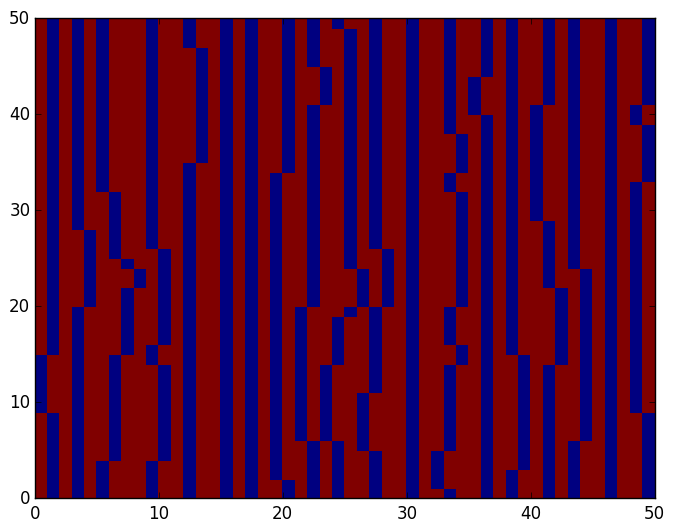

PyObject <matplotlib.collections.QuadMesh object at 0x314371f90>

In [15]:
new_start=Config(50)
new=copy(new_start)
@time for t in 1:100000
    new=Short_loop_E(new,0.3)
end
pcolormesh(new)

Vemos que de igual forma se da preferencia a los arreglos simétricos, pero estos no están formados uniformemente como en el caso de long loop

In [16]:
function Energía(config)
    Delta=0
    L=length(config[1,:])
    for i in 1:2:L
        for j in 1:L
            #hay dos tipos de casillas en las hileras nones, hay que diferenciarlas
            if mod(j,2)==0
                #si es simétrico se le da energía -ϵ, en caso contrario 0
                if config[i,j]==-config[mod1(i-1,L),mod1(j+1,L)]
                Delta-=1
                end
            else
                #si es simétrico se le da energía -ϵ, en caso contrario 0
                if config[i,j]==-config[mod1(i+1,L),mod1(j+1,L)]
                Delta-=1
                end
            end
        end
    end
    return Delta
end

Energía (generic function with 1 method)

##Comparación con el modelo energético

Genero de los algoritmos sin energía un arreglo random de 100x100

0
elapsed time: 19.188360538 seconds (15505 MB allocated, 20.32% gc time in 708 pauses with 0 full sweep)
-1850


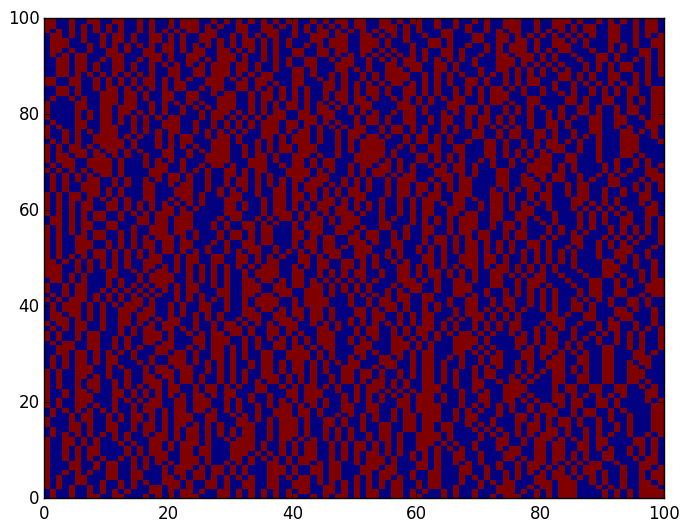

In [31]:
original=Config(100)
new_start=copy(original)
println(Energía(original))
@time for t in 1:10000
    new_start=Long_loop(new_start)
end
pcolormesh(new_start)
println(Energía(new_start))

####Long loop

elapsed time: 14.539694057 seconds (11149 MB allocated, 19.56% gc time in 510 pauses with 0 full sweep)
-3574


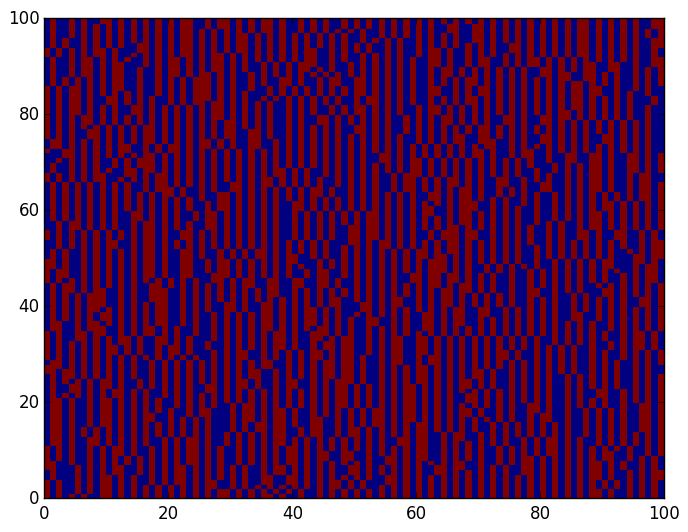

PyObject <matplotlib.collections.QuadMesh object at 0x316a8e710>

In [32]:
new=copy(new_start)
@time for t in 1:10000
    new=Long_loop_E(new,0.3)
end
println(Energía(new))
pcolormesh(new)

####Short loop

elapsed time: 8.711084289 seconds (8972 MB allocated, 27.15% gc time in 410 pauses with 0 full sweep)
-4546


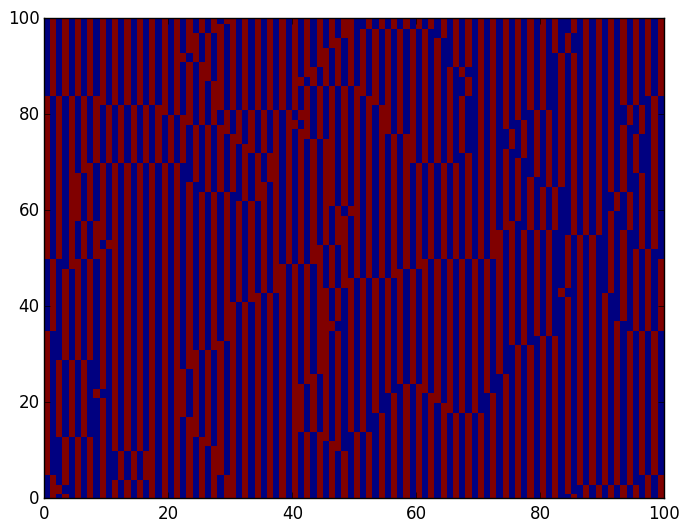

PyObject <matplotlib.collections.QuadMesh object at 0x3171a4710>

In [33]:
new=copy(new_start)
@time for t in 1:100000
    new=Short_loop_E(new,0.3)
end
println(Energía(new))
pcolormesh(new)

Es claro que el short loop con una configuración realmente random le gana al longloop. Las flechas arriba o abajo son de color ya sea azul o rojo, los vértices simétricos son aquellos que tienen a su izquierda de un color y a su derecha de otro, por lo que un arrego completamente simétrico serán franjas azules y rojas seguidas y continuas.

elapsed time: 87.059952417 seconds (90631 MB allocated, 27.12% gc time in 4137 pauses with 0 full sweep)


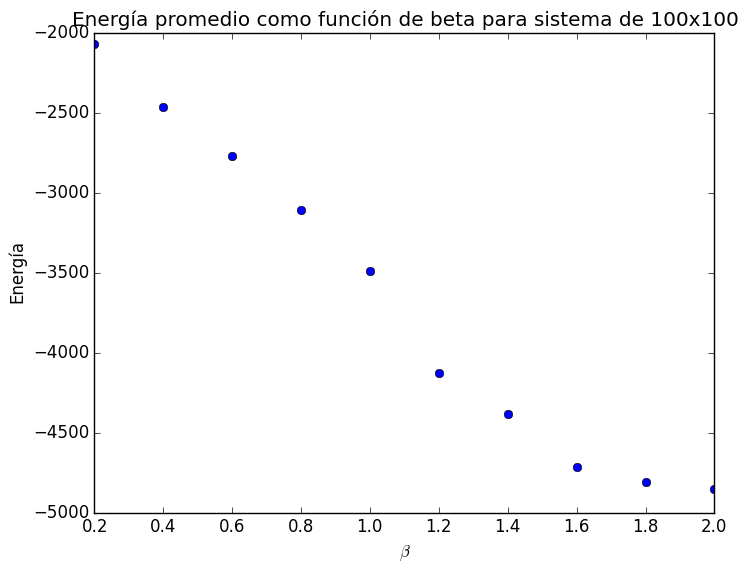

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x315868450>

In [34]:
new=copy(new_start)
betas=[]
energías=[]
@time for i in 1:10
    β=i*0.2
    push!(betas,β)
    for t in 1:100000
        new=Short_loop_E(new,1/β)
    end
    e=Energía(new)
    push!(energías,e)
end
title("Energía promedio como función de beta para sistema de 100x100")
xlabel(L"$\beta$")
ylabel("Energía")
plot(betas,energías,"o")

30
60
90


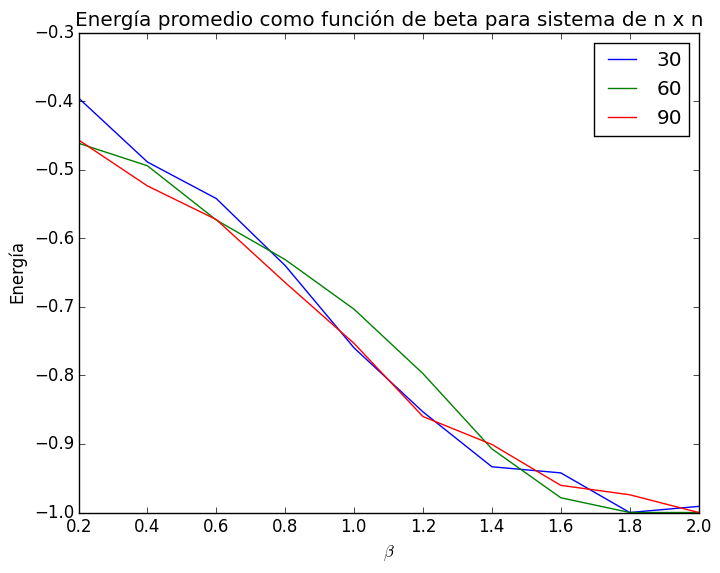

In [21]:
for n in 30:30:100
    new_start=Config(n)
    for t in 1:10000
        new_start=Long_loop(new_start)
    end
    betas=[]
    energías=[]
    for i in 1:10
        β=i*0.2
        push!(betas,β)
        for t in 1:800000
            new_start=Short_loop_E(new_start,1/β)
        end
        e=Energía(new_start)
        push!(energías,e)
    end
    println(n)
    energías/=abs(minimum(energías))
    title("Energía promedio como función de beta para sistema de n x n")
    xlabel(L"$\beta$")
    ylabel("Energía")
    plot(betas,energías, label=n)
    legend()
end

###Algunas conclusiones.

Podemos notar que hay una transición de fase con cualquier algoritmo. Nuestro mejor algoritmo fue el short loop, que puede manejar sistemas de 100x100 sin problemas. Con todo esto se puede ver que algo tan complicado como el hielo se puede simplificar radicalmente y llegar a resultados interesantes que nos muestran transiciones de fase. Finalmente, se puede mejorar un poco haciendo un arreglo diferente al hielo cuadrado. Se puede mejorar mucho más intentando una situación en 3D.